                 Generalized Linear Model Regression Results                  
Dep. Variable:             Claim_Made   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4960
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2874.7
Date:                Sat, 03 May 2025   Deviance:                       3281.5
Time:                        10:45:17   Pearson chi2:                 3.75e+03
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03375
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

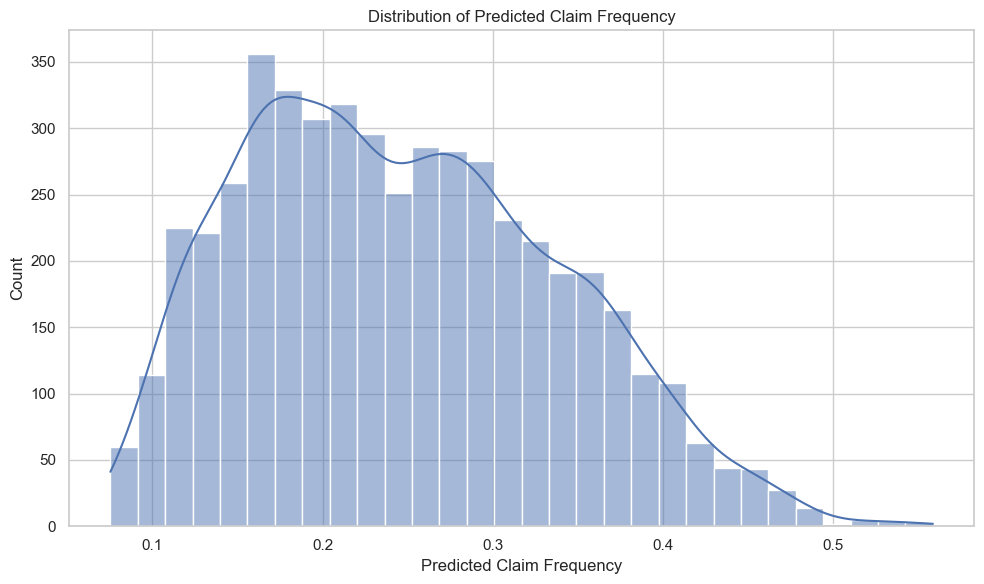

In [8]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Settings
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Step 2: Load cleaned dataset
df = pd.read_csv('../data/processed/device_insurance_data_enriched.csv')

# Step 3: Feature selection & encoding
model_df = df.copy()

# Drop unused columns
model_df = model_df.drop(columns=['Policy_ID', 'Claim_Cost', 'Plan_Price'])

# Convert categorical features to dummy variables
categorical_vars = ['Device_Type', 'Brand', 'Vendor', 'Region', 'Sales_Channel', 'Age_Band']
model_df = pd.get_dummies(model_df, columns=categorical_vars, drop_first=True)

# Step 4: Set up X (features), y (target)
X = model_df.drop(columns=['Claim_Made', 'Customer_Age', 'Retail_Price', 'Plan_Duration'])  # keep only dummies
y = model_df['Claim_Made']

# Convert any bools to ints and ensure numerics
X = X.astype(float)
y = pd.to_numeric(y, errors='coerce')

# Step 5: Add constant for GLM
X = sm.add_constant(X)

# Step 6: Fit Poisson GLM for Claim Frequency
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Step 7: View summary
print(poisson_results.summary())

# Step 8: Predict claim frequency
model_df['Predicted_Claim_Frequency'] = poisson_results.predict(X)

# Step 9: Merge with original data
df_with_freq = df.copy()
df_with_freq['Predicted_Claim_Frequency'] = model_df['Predicted_Claim_Frequency']

# Step 10: Save enriched dataset
df_with_freq.to_csv('../data/processed/device_insurance_with_freq_predictions.csv', index=False)
print("\n Frequency predictions saved to: ../data/processed/device_insurance_with_freq_predictions.csv")

# Optional: Plot predicted frequency vs actual
sns.histplot(df_with_freq['Predicted_Claim_Frequency'], bins=30, kde=True)
plt.title("Distribution of Predicted Claim Frequency")
plt.xlabel("Predicted Claim Frequency")
plt.tight_layout()
plt.show()

In [9]:
# Step: Create Frequency Relativity Table from Poisson GLM

import numpy as np
import pandas as pd

# Extract coefficients from the fitted model
coeffs = poisson_results.params

# Exponentiate coefficients to get relativity values
relativities = np.exp(coeffs)

# Create a table
relativity_table = pd.DataFrame({
    'Feature': coeffs.index,
    'Coefficient': coeffs.values,
    'Relativity': relativities.values
})

# Sort by relativity (optional)
relativity_table = relativity_table.sort_values(by='Relativity', ascending=False).reset_index(drop=True)

# Preview
relativity_table.head()

,Feature,Coefficient,Relativity
0,Brand_Bosch,0.482717,1.620472
1,Brand_Whirlpool,0.352563,1.422709
2,Brand_Beats,0.343124,1.409344
3,Brand_Sony,0.315355,1.370745
4,Brand_Panasonic,0.276549,1.318572


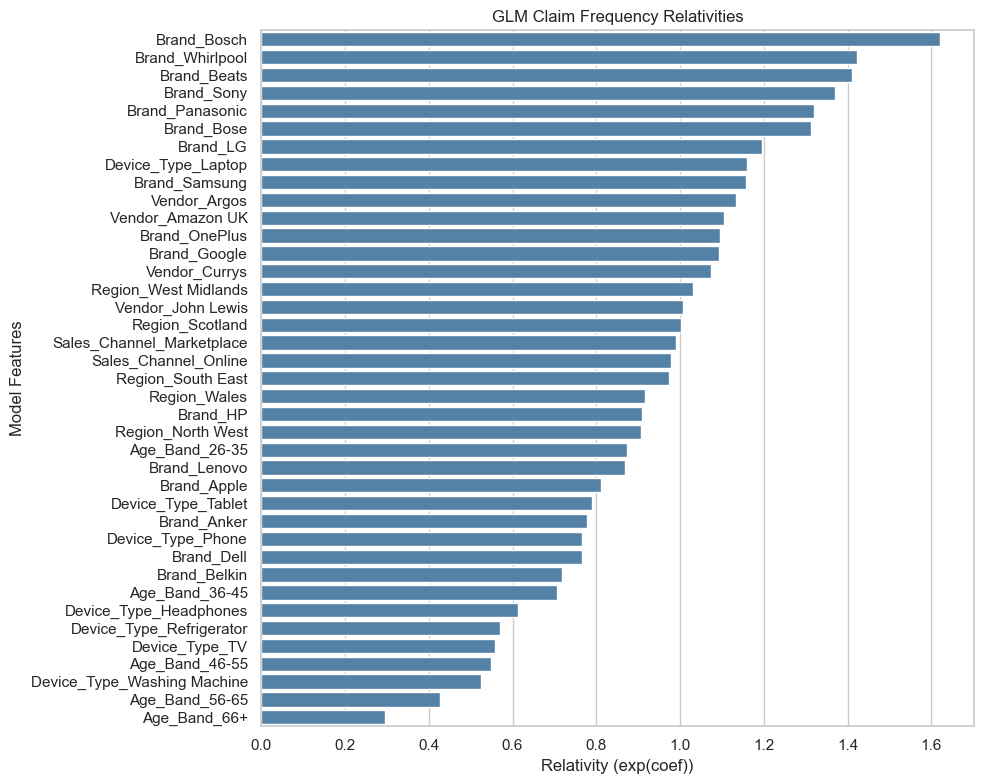

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot clean chart without warning
plt.figure(figsize=(10, 8))
sns.barplot(
    data=plot_df,
    x='Relativity',
    y='Feature',
    color='steelblue'   # Use a single color to avoid palette issues
)

plt.title("GLM Claim Frequency Relativities")
plt.xlabel("Relativity (exp(coef))")
plt.ylabel("Model Features")
plt.tight_layout()
plt.savefig('../reports/figures/frequency_relativity_chart.png', bbox_inches='tight')
plt.show()